# C1D_SS

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

In [26]:
model_dir = 'default_biogeochem/'
model_dir = 'initialized_biogeochemistry/'
model_dir = 'showing_inertial_currents/'

#model_dir = './'

In [27]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['figure.figsize'] = [8.0, 6.0]

In [28]:
ymin = 400

## Bathymetry

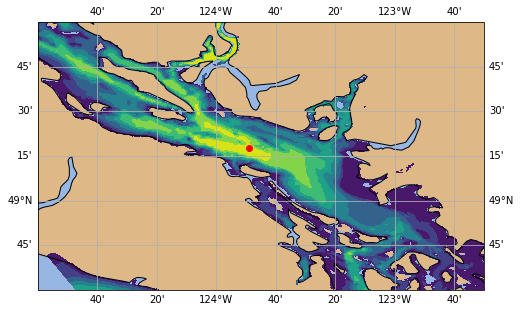

In [5]:
bathy = xr.open_dataset('bathy_meter.nc')

plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-125, -122.5, 48.5, 50], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, color='#DEB887')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# The data are defined in lat/lon coordinate system, so PlateCarree()
# is the appropriate choice:
data_crs = ccrs.PlateCarree()


ax.contourf(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, transform=data_crs)

y = 501
x = 241
ax.plot( bathy.nav_lon[y,x], bathy.nav_lat[y,x], 'ro', transform=data_crs)

## Surface Forcing

In [6]:
@interact(t=(0, 23, 1))
def plot_winds(t=0):
    
    ds = xr.open_dataset('ATMDATA/ops_y2016m02d01.nc')
    wind = ds.isel(time_counter=t)
    
    plt.figure(figsize=(8,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-125, -122.5, 48.5, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, color='#DEB887')
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # The data are defined in lat/lon coordinate system, so PlateCarree()
    # is the appropriate choice:
    data_crs = ccrs.PlateCarree()

    uv_mag = np.sqrt(wind.u_wind**2 + wind.v_wind**2)
    ax.contourf(wind.nav_lon, wind.nav_lat, uv_mag, transform=data_crs, 
               levels = np.linspace(0, 10, 10))

    ax.quiver(wind.nav_lon[::3, ::3], wind.nav_lat[::3, ::3],  
              wind.u_wind[::3, ::3], wind.v_wind[::3, ::3], 
              pivot='mid', units='width', scale=100,
              transform=data_crs)

    y = 501
    x = 241
    ax.plot( bathy.nav_lon[y,x], bathy.nav_lat[y,x], 'ro', transform=data_crs)


    y = 147
    x = 137
    ax.plot( wind.nav_lon[y,x], wind.nav_lat[y,x], 'wo', transform=data_crs)
    
    timestr = np.datetime_as_string(ds.time_counter[t], unit='s')
    plt.title(timestr)

interactive(children=(IntSlider(value=0, description='t', max=23), Output()), _dom_classes=('widget-interact',…

(16831.952083333334, 16832.952083333334)

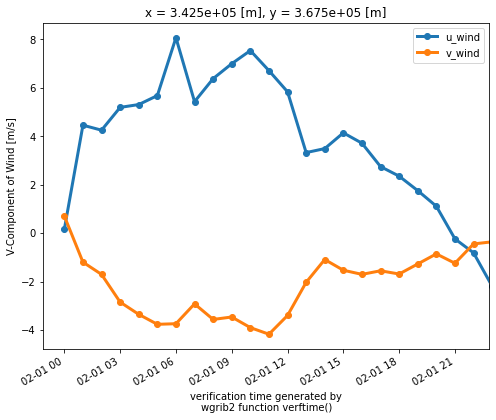

In [7]:
ds = xr.open_dataset('ATMDATA/ops_y2016m02d01.nc')
ds.isel(x=137, y=147).u_wind.plot(marker='o', label='u_wind')
ds.isel(x=137, y=147).v_wind.plot(marker='o', label='v_wind')
plt.legend()
#plt.xlim('2016-02-01 00:00:00', '2016-02-01 12:00:00')
xmin, xmax = plt.xlim()
plt.xlim(xmin, xmin + 1)

## Surface Stress

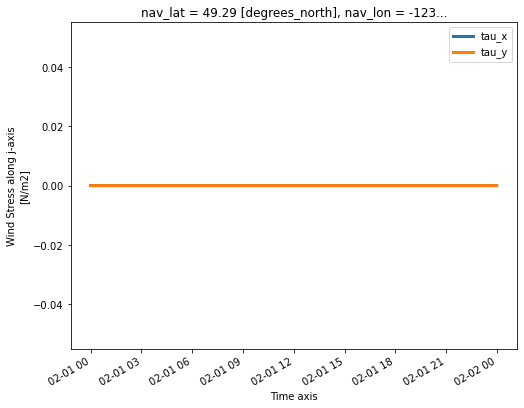

In [43]:
ds = xr.open_dataset(os.path.join(model_dir, 'SalishSea_1ts_20160201_20160201_grid_U.nc'))    
ds.isel(x=1, y=1).surface_downward_x_stress.plot(label='tau_x')
ds = xr.open_dataset(os.path.join(model_dir, 'SalishSea_1ts_20160201_20160201_grid_V.nc'))    
ds.isel(x=1, y=1).surface_downward_y_stress.plot(label='tau_y')
plt.legend()


## Velocity profiles

Initialize the velocity profile with values from 3D model (on u-grid an v-grid)

Text(0.5, 1.0, "['2016-02-01T12:00:00']")

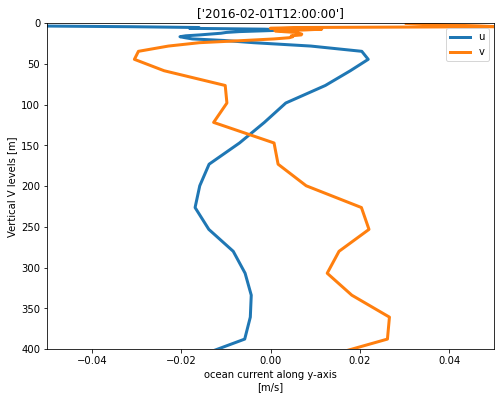

In [30]:
ds = xr.open_dataset('source_model/SalishSeaCast-VNR002_1d_grid_U_y2016m02d01.nc')
u_init = ds.vozocrtx.isel(x=241, y=501, time_counter=0)
ds = xr.open_dataset('source_model/SalishSeaCast-VNR002_1d_grid_V_y2016m02d01.nc')
v_init = ds.vomecrty.isel(x=241, y=501, time_counter=0)

u_init.plot(y='depthu', label='u')
v_init.plot(y='depthv', label='v')
plt.ylim(ymin, 0)
plt.xlim(-0.05, 0.05)
plt.legend()
timestr = np.datetime_as_string(ds.time_counter, unit='s')
plt.title(timestr)

### Initial fields

Projected initial fields on to t-grid

Text(0.5, 1.0, '2016-02-01T00:00:40')

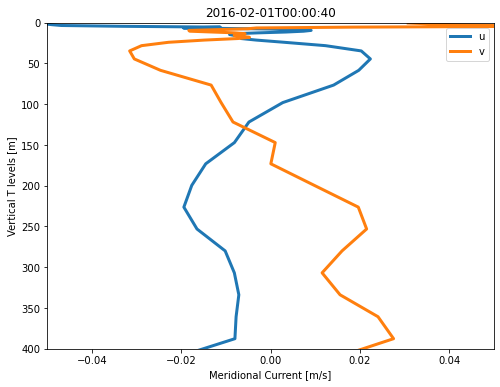

In [31]:
ds = xr.open_dataset(os.path.join(model_dir, 'output.init.nc'))
ds.vozocrtx.isel(x=1, y=1, time_counter=0).plot(y='deptht', label='u')
ds.vomecrty.isel(x=1, y=1, time_counter=0).plot(y='deptht', label='v')
plt.ylim(ymin, 0)
plt.xlim(-0.05, 0.05)
plt.legend()
timestr = np.datetime_as_string(ds.time_counter[0], unit='s')
plt.title(timestr)

### 3D Model UV profile changing with time

In [44]:
@interact(t=(0, 71, 1))
def plot_uv(t=0):
    ds = xr.open_mfdataset('model/SalishSeaCast-VNR002_1h_grid_U_*.nc')
    u = ds.isel(x=241, y=501, time_counter=t).vozocrtx
    ds = xr.open_mfdataset('model/SalishSeaCast-VNR002_1h_grid_V_*.nc')
    v = ds.isel(x=241, y=501, time_counter=t).vomecrty
  
    u.plot(y='depthu', label='u')
    v.plot(y='depthv', label='v')
    
    plt.ylim(ymin, 0)
    plt.xlim(-0.05, 0.05)
    plt.legend()
    timestr = np.datetime_as_string(ds.time_counter[t], unit='s')
    plt.title(timestr)

interactive(children=(IntSlider(value=0, description='t', max=71), Output()), _dom_classes=('widget-interact',…

### UV profiles changing with time

In [47]:
@interact(t=(0, 2159, 1))
def plot_uv(t=0):
    ds = xr.open_dataset(os.path.join(model_dir, 'SalishSea_1ts_20160201_20160201_grid_U.nc'))
    u = ds.isel(x=1, y=1, time_counter=t).vozocrtx
    ds = xr.open_dataset(os.path.join(model_dir, 'SalishSea_1ts_20160201_20160201_grid_V.nc'))
    v = ds.isel(x=1, y=1, time_counter=t).vomecrty
  
    u.plot(y='depthu', label='u')
    v.plot(y='depthv', label='v')
    
    plt.ylim(ymin, 0)
    plt.xlim(-0.05, 0.05)
    plt.legend()
    timestr = np.datetime_as_string(ds.time_counter[t], unit='s')
    plt.title(timestr)

interactive(children=(IntSlider(value=0, description='t', max=2159), Output()), _dom_classes=('widget-interact…

In [46]:
@interact(z=(0, 400, 1))
def plot_uv(z=0):
    ds = xr.open_mfdataset('model/SalishSeaCast-VNR002_1h_grid_U_*.nc')
    u = ds.isel(x=241, y=501).sel(depthu=z, method='nearest').vozocrtx
    ds = xr.open_mfdataset('model/SalishSeaCast-VNR002_1h_grid_V_*.nc')
    v = ds.isel(x=241, y=501).sel(depthv=z, method='nearest').vomecrty
  
    u.plot(x='time_counter', label='u')
    v.plot(x='time_counter', label='v')
    
    plt.legend()

interactive(children=(IntSlider(value=0, description='z', max=400), Output()), _dom_classes=('widget-interact'…

In [33]:
@interact(z=(0, 400, 1))
def plot_uv(z=0):
    ds = xr.open_dataset(os.path.join(model_dir, 'SalishSea_1ts_20160201_20160201_grid_U.nc'))
    u = ds.isel(x=1, y=1).sel(depthu=z, method='nearest').vozocrtx
    ds = xr.open_dataset(os.path.join(model_dir, 'SalishSea_1ts_20160201_20160201_grid_V.nc'))
    v = ds.isel(x=1, y=1).sel(depthv=z, method='nearest').vomecrty
  
    u.plot(x='time_counter', label='u')
    v.plot(x='time_counter', label='v')
    
    #plt.ylim(-0.05, 0.05)
    #plt.xlim(-0.05, 0.05)
    plt.legend()
    

interactive(children=(IntSlider(value=0, description='z', max=400), Output()), _dom_classes=('widget-interact'…

In [12]:
π = np.pi
Ω = 2*π/(24*3600)
Ω

7.27220521664304e-05

In [34]:
ϕ = np.deg2rad(49.29)
f = 2*Ω*np.sin(ϕ)
f

0.00011024961443512124

In [37]:
inertial_period = 2*π/f
inertial_period
print(f'interial period = {inertial_period/3600}')

interial period = 15.83070617468151


## Temperature/Salinity Profiles

In [34]:
@interact(t=(0, 2159, 1))
def plot_ts(t=0):
    fig, axs = plt.subplots(1, 2, figsize=(8, 6))
    ds = xr.open_dataset(os.path.join(model_dir, 'SalishSea_1ts_20160201_20160201_grid_T.nc'))
    temp = ds.isel(x=1, y=1, time_counter=t).votemper
    temp.plot(y='deptht', ax=axs[0])
    axs[0].set_ylim(ymin, 0)
    axs[0].set_xlim(6, 12)
    axs[0].set_title('Temperature')
    
    salinity = ds.isel(x=1, y=1, time_counter=t).vosaline
    salinity.plot(y='deptht', ax=axs[1])
    axs[1].set_ylim(ymin, 0)
    axs[1].set_xlim(22, 33)
    axs[1].set_title('Salinity')
       
    timestr = np.datetime_as_string(ds.time_counter[t], unit='s')
    plt.figtext(0.5, 0.98, timestr , horizontalalignment='center', verticalalignment='top', fontsize=16)

interactive(children=(IntSlider(value=0, description='t', max=2159), Output()), _dom_classes=('widget-interact…

## Silicates

In [48]:
@interact(t=(0, 2159, 1))
def plot_silicates(t=0):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    ds = xr.open_dataset(os.path.join(model_dir, 'SalishSea_1ts_20160201_20160201_ptrc_T.nc'))
    silicon = ds.isel(x=1, y=1, time_counter=t).silicon
    silicon.plot(y='deptht', ax=axs[0])
    axs[0].set_ylim(400, 0)
    axs[0].set_xlim(40, 70)
    axs[0].set_title('Silicon')
    
    biogenic_silicon = ds.isel(x=1, y=1, time_counter=t).biogenic_silicon
    biogenic_silicon.plot(y='deptht', ax=axs[1])
    axs[1].set_ylim(400, 0)
    axs[1].set_xlim(-0.05, 0.65)
    axs[1].set_title('Biogenic Silicon')
    
    diatoms = ds.isel(x=1, y=1, time_counter=t).diatoms
    diatoms.plot(y='deptht', ax=axs[2])
    axs[2].set_ylim(400, 0)
    axs[2].set_xlim(-0.05, 0.65)
    axs[2].set_title('Diatoms')
    
    timestr = np.datetime_as_string(ds.time_counter[t], unit='s')
    plt.figtext(0.5, 0.98, timestr , horizontalalignment='center', verticalalignment='top', fontsize=16)

interactive(children=(IntSlider(value=0, description='t', max=2159), Output()), _dom_classes=('widget-interact…